In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [4]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [92]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [40]:
#Part 1: Analyzing Best-Seller Trends Across Product Categories
#Objective: Understand the relationship between product categories and their best-seller status.

#Crosstab Analysis:
#Create a crosstab between the product category and the isBestSeller status.
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

sorted_crosstab = crosstab_result.sort_values(by=True, axis=0, ascending=False)

sorted_crosstab['Bestseller%'] = sorted_crosstab[True] / (sorted_crosstab[True] + sorted_crosstab[False]) * 100

sorted_crosstab.sort_values(by='Bestseller%', axis=0, ascending=False).head(10)

#Are there categories where being a best-seller is more prevalent?
## - Yes, the top few listed below are those where there is greater prevalence of best-sellers
## (Grocery, Smart Home Secutiry & Lighting, Health & Personal Care, etc.)


isBestSeller,False,True,Bestseller%
category,,,
Grocery,9008,556,5.813467
Smart Home Security & Lighting,98,6,5.769231
Health & Personal Care,9017,552,5.768628
Mobile Phone Accessories,248,11,4.247104
Power & Hand Tools,8353,306,3.533895
"Billiard, Snooker & Pool",241,8,3.212851
Pet Supplies,9152,285,3.020028
Home Brewing & Wine Making,239,7,2.845528
Wind Instruments,243,7,2.800000


In [42]:
# 2. Statistical Tests:
# Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
from scipy.stats import chi2_contingency
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

In [ ]:
## The chi2 p value of 0 indicates there is there is significant association between these variables

In [44]:
# Compute Cramér's V to understand the strength of association between best-seller status and category

from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

0.1222829439760564

In [ ]:
## This association value is low, meaning a weak relationship between these categorical variables, despite its statistical significance

In [64]:
sorted_crosstab.columns

Index([False, True, 'Bestseller%'], dtype='object', name='isBestSeller')

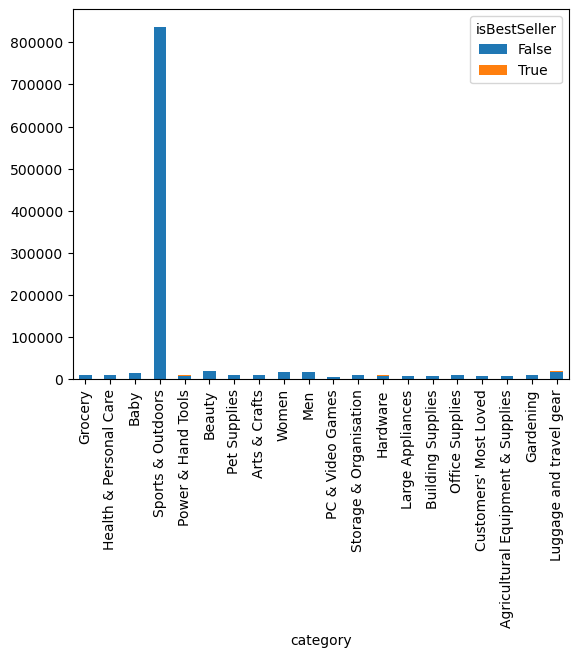

In [90]:
# 3. Visualizations:
# Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

crosstab_result.sort_values(by=True, axis=0, ascending=False).head(20).plot(kind="bar", stacked=True);

Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.
For this purpose, we can use the IQR (Interquartile Range) method. 
Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5
times the IQR will be considered outliers and removed from the dataset.
The next steps will be done with the dataframe without outliers.

In [94]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    return outliers

def delete_col_outliers(df, col):
    df_filt = df.copy()
    df_filt = df_filt[~df_filt[col].isin(tukeys_test_outliers(df_filt[col]))]
    return(df_filt)

filt_df = delete_col_outliers(df, 'price')

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [96]:
filt_df.shape

(2115963, 9)

In [98]:
df.shape

(2443651, 9)

Violin Plots:

Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
Which product category tends to have the highest median price? Don't filter here by top categories.

In [113]:
filt_df.groupby('category')['uid'].count().sort_values(ascending=False)

cat_list = list(filt_df.groupby('category')['uid'].count().sort_values(ascending=False).head(20).index)

cat_list

['Sports & Outdoors',
 'Beauty',
 'Bath & Body',
 'Manicure & Pedicure Products',
 'Handmade Clothing, Shoes & Accessories',
 'Make-up',
 'Skin Care',
 'Hair Care',
 'Birthday Gifts',
 'Handmade Gifts',
 'Handmade Home Décor',
 'Luggage and travel gear',
 'Women',
 'Fragrances',
 'Handmade Kitchen & Dining',
 'Handmade Artwork',
 'Handmade Home & Kitchen Products',
 'Handmade Jewellery',
 'Men',
 'Baby']

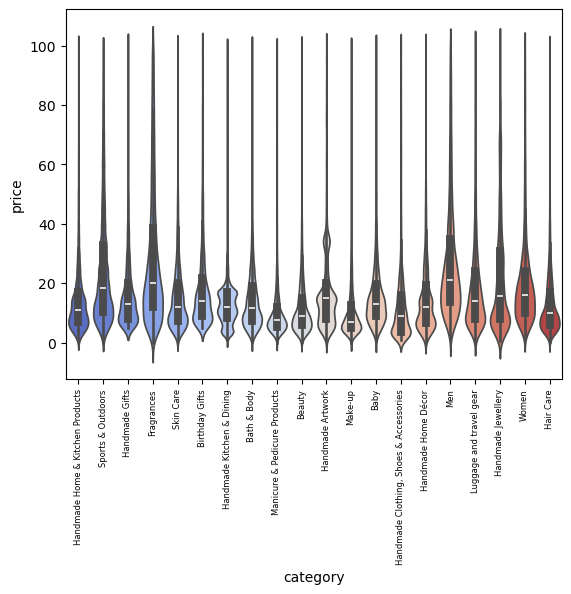

In [123]:
filt_cat_df = filt_df[filt_df['category'].isin(cat_list)]

sns.violinplot(data=filt_cat_df, x='category', y='price', palette="coolwarm", hue='category', legend=False);
plt.xticks(fontsize=6, rotation=90);


Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.

In [129]:
cat_list10 = cat_list[:10]

cat_list10

['Sports & Outdoors',
 'Beauty',
 'Bath & Body',
 'Manicure & Pedicure Products',
 'Handmade Clothing, Shoes & Accessories',
 'Make-up',
 'Skin Care',
 'Hair Care',
 'Birthday Gifts',
 'Handmade Gifts']

In [136]:
filt_cat10_df = filt_df[filt_df['category'].isin(cat_list10)]

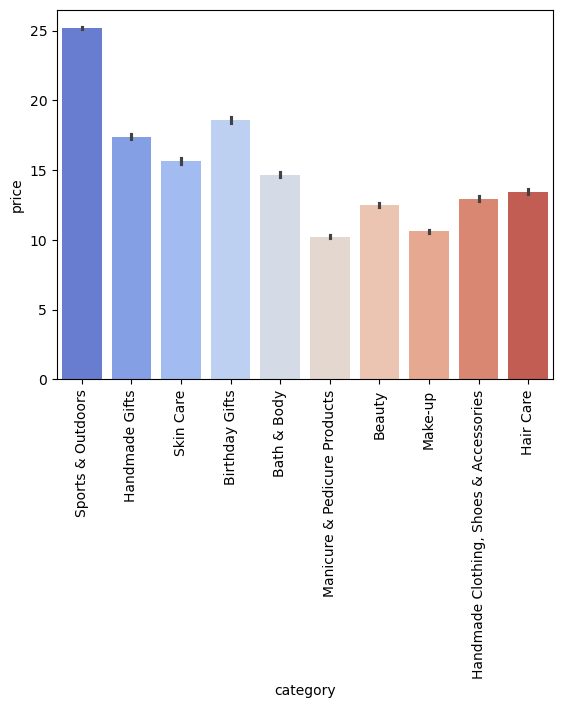

In [140]:
sns.barplot(data=filt_cat10_df, x='category', y='price', palette="coolwarm", hue='category', legend=False);
plt.xticks(fontsize=10, rotation=90);

Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

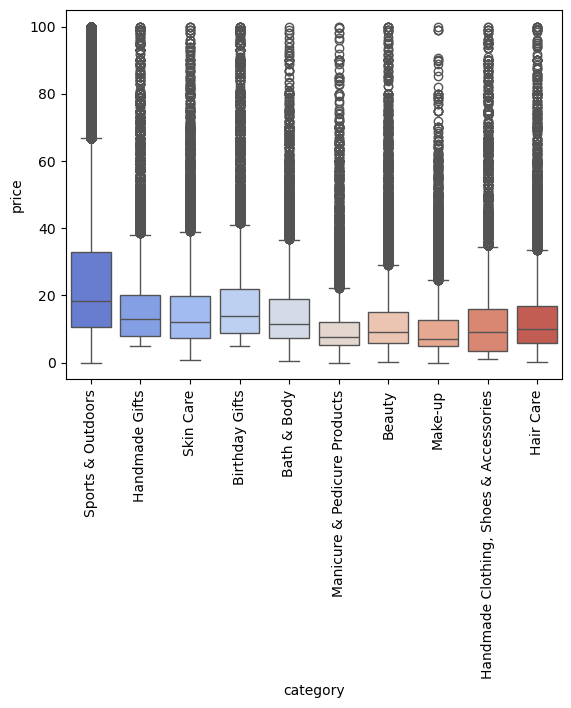

In [146]:
sns.boxplot(data=filt_cat10_df, x='category', y='price', palette="coolwarm", hue='category', legend=False);
plt.xticks(fontsize=10, rotation=90);

Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

Correlation Coefficients:

Calculate the correlation coefficient between price and stars.
Is there a significant correlation between product price and its rating?

In [151]:
correlation = filt_df['price'].corr(filt_df['stars'])
correlation

-0.0776729987818137

In [ ]:
#There is no correlation between price and rating

Visualizations:

Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
Use a correlation heatmap to visualize correlations between all numerical variables.
Examine if product prices typically follow a normal distribution using a QQ plot.

In [ ]:
#sns.scatterplot(data=filt_cat_df, x='stars', y='price', hue='category');

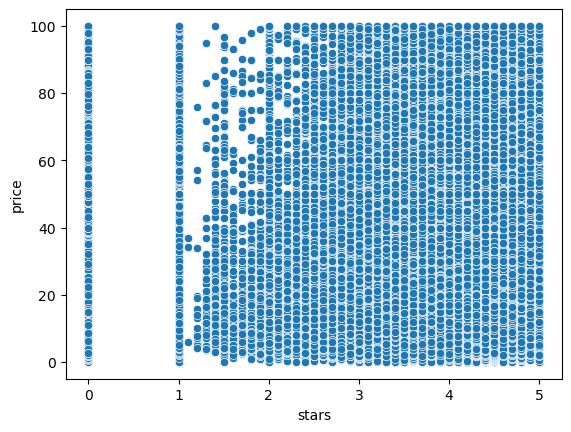

In [159]:
sns.scatterplot(data=filt_df, x='stars', y='price');

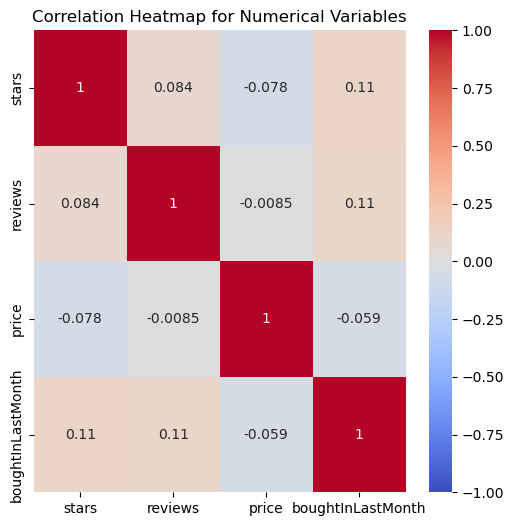

In [165]:
filt_df_num = filt_df[['stars', 'reviews', 'price', 'boughtInLastMonth']]

correlation_matrix = filt_df_num.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(6, 6))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.title("Correlation Heatmap for Numerical Variables")
plt.show()

In [ ]:
#No real correlation between numerical columns

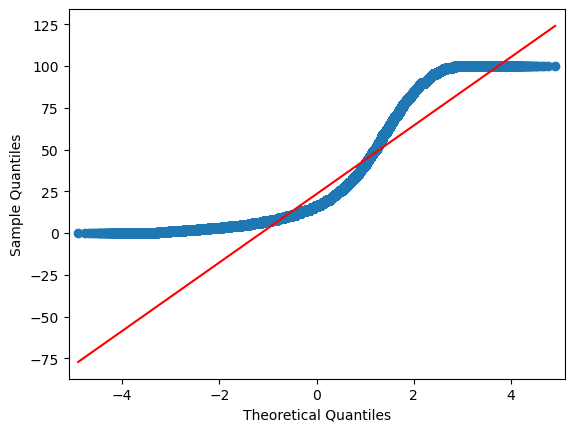

In [167]:
import statsmodels.api as sm

sm.qqplot(filt_df['price'], line='s');

In [ ]:
#Price data is definitely not normally skewed